<a href="https://colab.research.google.com/github/Sphad7/inteligencia-artificial/blob/main/UOH_COM4402_Tarea_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Cristian Herrera

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

## Subir datasets de dígitos (train)

In [ ]:
!wget raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
!wget raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt

URL transformed to HTTPS due to an HSTS policy
--2023-10-27 18:48:30--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt.7’

1_digits_train.txt. 100%[===================>] 625.59K  --.-KB/s    in 0.03s   

2023-10-27 18:48:30 (19.1 MB/s) - ‘1_digits_train.txt.7’ saved [640604/640604]

URL transformed to HTTPS due to an HSTS policy
--2023-10-27 18:48:30--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.git

## Leer dataset de dígitos

In [ ]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [ ]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [ ]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [ ]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [ ]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-7-9f48500b620a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-7-9f48500b620a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-7-9f48500b620a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

In [ ]:
df_train

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


## Crearción de modelos

In [ ]:
# Caso (a) - 10 neuronas en la capa oculta, ReLU y 1000 épocas:
model_a = nn.Sequential(
    nn.Linear(64, 10),  # Capa oculta con 10 neuronas
    nn.ReLU(),
    nn.Linear(10,10)    # Capa de salida con 10 clases
)

# Caso (b) - 40 neuronas en la capa oculta, ReLU y 1000 épocas:
model_b = nn.Sequential(
    nn.Linear(64, 40),  # Capa oculta con 40 neuronas
    nn.ReLU(),
    nn.Linear(40, 10),  # Capa de salida con 10 clases
)

# Caso (c) - 10 neuronas en la capa oculta, Tanh y 1000 épocas:
model_c = nn.Sequential(
    nn.Linear(64, 10),  # Capa oculta con 10 neuronas
    nn.Tanh(),
    nn.Linear(10, 10),  # Capa de salida con 10 clases
)

# Caso (d) - 40 neuronas en la capa oculta, Tanh y 1000 épocas:
model_d = nn.Sequential(
    nn.Linear(64, 40),  # Capa oculta con 40 neuronas
    nn.Tanh(),
    nn.Linear(40, 10),  # Capa de salida con 10 clases
)

# Caso (e) - 2 capas ocultas (10 y 10 neuronas), ReLU y 1000 épocas:
model_e = nn.Sequential(
    nn.Linear(64, 10),  # Primera capa oculta con 10 neuronas
    nn.ReLU(),
    nn.Linear(10, 10),  # Segunda capa oculta con 10 neuronas
    nn.ReLU(),
    nn.Linear(10, 10),  # Capa de salida con 10 clases
)

# Caso (f) - 2 capas ocultas (40 y 40 neuronas), ReLU y 1000 épocas:
model_f = nn.Sequential(
    nn.Linear(64, 40),  # Primera capa oculta con 40 neuronas
    nn.ReLU(),
    nn.Linear(40, 40),  # Segunda capa oculta con 40 neuronas
    nn.ReLU(),
    nn.Linear(40, 10),  # Capa de salida con 10 clases
)


## Crear datasets y dataloaders para pytorch (train)

In [ ]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [ ]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Funciones

In [ ]:
def train(model, dataloader_train, dataloader_val, labels_train, labels_val, device, criterion, optimizer):
    # Inicializar variables para el seguimiento de pérdidas y precisión

    train_losses = []  # valores de loss de entrenamiento
    val_losses = []    # valores de loss de validación
    best_val_loss = float('inf')  # Mejor loss observado
    epoch_times = []  # Inicializar una lista para registrar el tiempo de cada época

    correct_train = 0
    total_train = 0
    correct_val = 0
    total_val = 0


    start = time.time()

    # Loop over the dataset multiple times
    for epoch in range(1000):
        model.train()
        total_train_loss = 0.0

        epoch_start_time = time.time()  # Registrar el tiempo de inicio de la época

        # Train on the current epoch
        for i, data in enumerate(dataloader_train, 0):
            # Process the current batch
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() # backpropagation
            optimizer.step()

            # Por completar: calcule la pérdida de validación y acurracy en el batch actual
            total_train_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            # Por completar: calcule la pérdida de validación y acurracy en la época actual
            for i, data in enumerate(dataloader_val, 0):
                inputs = data["features"].to(device)
                labels = data["labels"].to(device)
                outputs = model(inputs)
                losss = criterion(outputs, labels)
                total_val_loss += losss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_end_time = time.time()  # Registrar el tiempo de finalización de la época

        avg_train_loss = total_train_loss / len(dataloader_train)
        avg_val_loss = total_val_loss / len(dataloader_val)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        train_loss = avg_train_loss
        val_loss = avg_val_loss


        # Calcular el tiempo transcurrido en la época actual
        epoch_elapsed_time = epoch_end_time - epoch_start_time

        # Registrar el tiempo de la época en la lista de epoch_times
        epoch_times.append(epoch_elapsed_time)

        # Si el loss de validación comienza a subir, detener el entrenamiento
        if epoch > 0 and val_loss > best_val_loss:
            print("Early stopping at epoch", epoch)
            break

        # Guardar el mejor loss de validación observado
        if epoch == 0 or val_loss < best_val_loss:
            best_val_loss = val_loss

        train_accuracy = 100 * correct_train / total_train
        val_accuracy = 100 * correct_val / total_val

        # Por hacer: imprima la pérdida de entrenamiento/validación y acurracy en la época actual
        print('Epoch %d: Train Loss: %.4f | Train Accuracy: %.2f%% | Validation Loss: %.4f | Validation Accuracy: %.2f%% | Time Elapsed: %.2f seconds' % (epoch, avg_train_loss, train_accuracy, avg_val_loss, val_accuracy, epoch_elapsed_time))

    end = time.time()
    total_elapsed_time = end - start

    print('Finished Training, total time %f seconds' % total_elapsed_time)

    # Graficar el loss de entrenamiento y validación en función del tiempo
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(epoch_times), train_losses, label='Training Loss', color='blue')
    plt.plot(np.cumsum(epoch_times), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Time Elapsed (seconds)')
    plt.ylabel('Loss')
    plt.title("Model loss on train and validation")
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
def calculate_normalized_confusion_matrix_and_accuracy(model, dataloader, device):
    model.eval()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data in dataloader:
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize="true")

    return accuracy, conf_matrix

def plot_normalized_confusion_matrix(conf_matrix, accuracy, titlee):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix ' + titlee +f' (Accuracy: {accuracy:.2f})')
    plt.colorbar()

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, f'{conf_matrix[i, j]:.3f}', horizontalalignment="center", color="white" if conf_matrix[i, j] > 0.5 else "black")

    plt.xticks(range(conf_matrix.shape[1]))
    plt.yticks(range(conf_matrix.shape[0]))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


## Entrenamiento

### Caso (a)

Epoch 0: Train Loss: 2.2219 | Train Accuracy: 21.10% | Validation Loss: 2.1096 | Validation Accuracy: 34.79% | Time Elapsed: 0.26 seconds
Epoch 1: Train Loss: 2.0371 | Train Accuracy: 29.40% | Validation Loss: 1.9237 | Validation Accuracy: 40.15% | Time Elapsed: 0.17 seconds
Epoch 2: Train Loss: 1.8472 | Train Accuracy: 35.08% | Validation Loss: 1.7243 | Validation Accuracy: 45.19% | Time Elapsed: 0.12 seconds
Epoch 3: Train Loss: 1.6536 | Train Accuracy: 40.20% | Validation Loss: 1.5249 | Validation Accuracy: 49.79% | Time Elapsed: 0.10 seconds
Epoch 4: Train Loss: 1.4658 | Train Accuracy: 44.88% | Validation Loss: 1.3442 | Validation Accuracy: 53.73% | Time Elapsed: 0.13 seconds
Epoch 5: Train Loss: 1.2884 | Train Accuracy: 48.90% | Validation Loss: 1.1765 | Validation Accuracy: 57.04% | Time Elapsed: 0.11 seconds
Epoch 6: Train Loss: 1.1237 | Train Accuracy: 52.53% | Validation Loss: 1.0388 | Validation Accuracy: 60.14% | Time Elapsed: 0.11 seconds
Epoch 7: Train Loss: 0.9786 | Trai

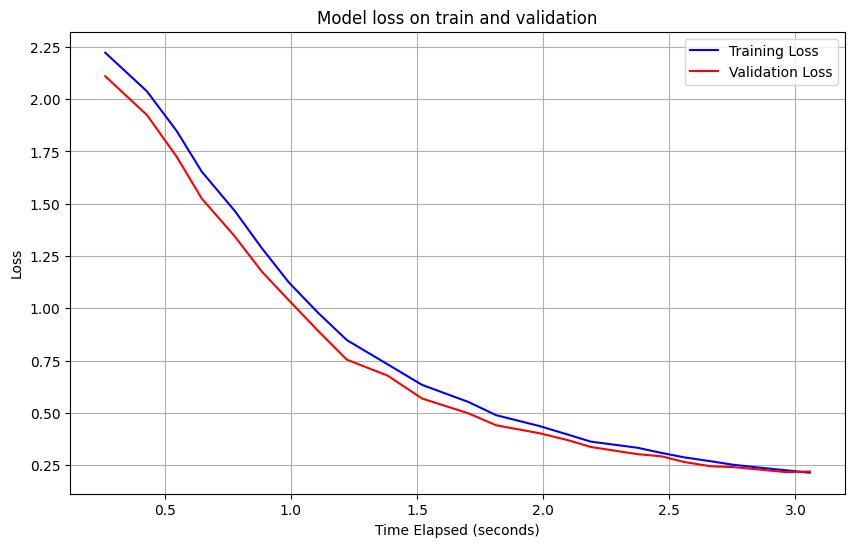

In [ ]:
device = torch.device('cuda')

model_a = model_a.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_a.parameters(), lr=1e-3)

train(model_a, dataloader_train, dataloader_val, labels_train, labels_val, device, criterion, optimizer)

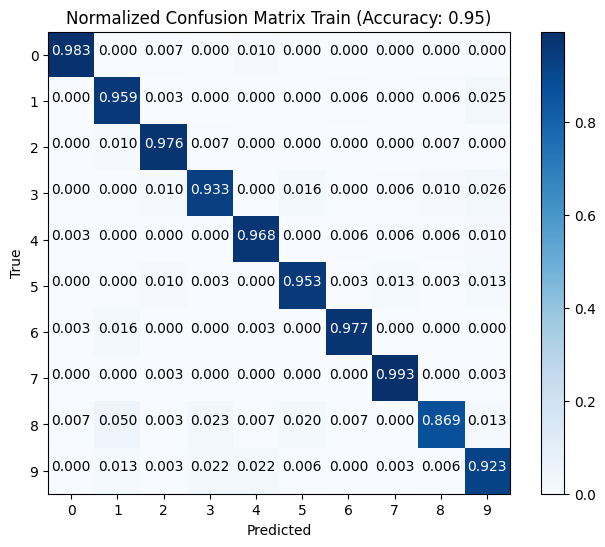

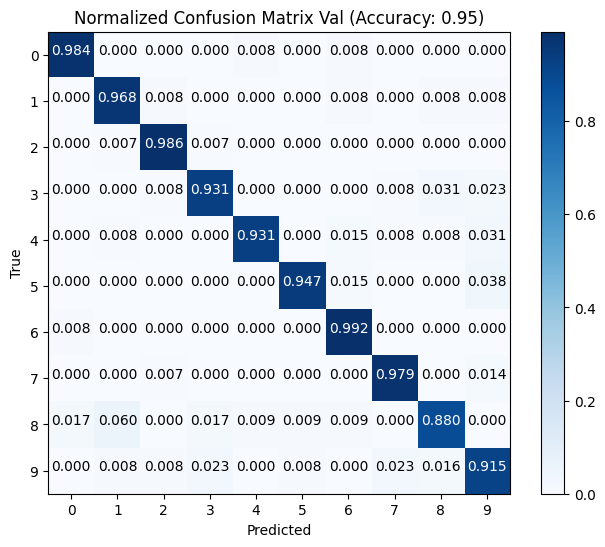

In [ ]:
# Conjunto de entrenamiento
train_accuracy, train_confusion_matrix = calculate_normalized_confusion_matrix_and_accuracy(model_a, dataloader_train, device)
plot_normalized_confusion_matrix(train_confusion_matrix, train_accuracy, "Train")

# Conjunto de validación
val_accuracy, val_confusion_matrix = calculate_normalized_confusion_matrix_and_accuracy(model_a, dataloader_val, device)
plot_normalized_confusion_matrix(val_confusion_matrix, val_accuracy, "Val")


### Caso (b)

Epoch 0: Train Loss: 2.1550 | Train Accuracy: 26.33% | Validation Loss: 1.9530 | Validation Accuracy: 51.03% | Time Elapsed: 0.12 seconds
Epoch 1: Train Loss: 1.7486 | Train Accuracy: 44.81% | Validation Loss: 1.5300 | Validation Accuracy: 62.18% | Time Elapsed: 0.16 seconds
Epoch 2: Train Loss: 1.3255 | Train Accuracy: 55.40% | Validation Loss: 1.1208 | Validation Accuracy: 68.15% | Time Elapsed: 0.14 seconds
Epoch 3: Train Loss: 0.9531 | Train Accuracy: 62.15% | Validation Loss: 0.8202 | Validation Accuracy: 72.55% | Time Elapsed: 0.09 seconds
Epoch 4: Train Loss: 0.6784 | Train Accuracy: 67.28% | Validation Loss: 0.5903 | Validation Accuracy: 75.89% | Time Elapsed: 0.11 seconds
Epoch 5: Train Loss: 0.4965 | Train Accuracy: 71.16% | Validation Loss: 0.4586 | Validation Accuracy: 78.51% | Time Elapsed: 0.18 seconds
Epoch 6: Train Loss: 0.3832 | Train Accuracy: 74.24% | Validation Loss: 0.3506 | Validation Accuracy: 80.53% | Time Elapsed: 0.10 seconds
Epoch 7: Train Loss: 0.3104 | Trai

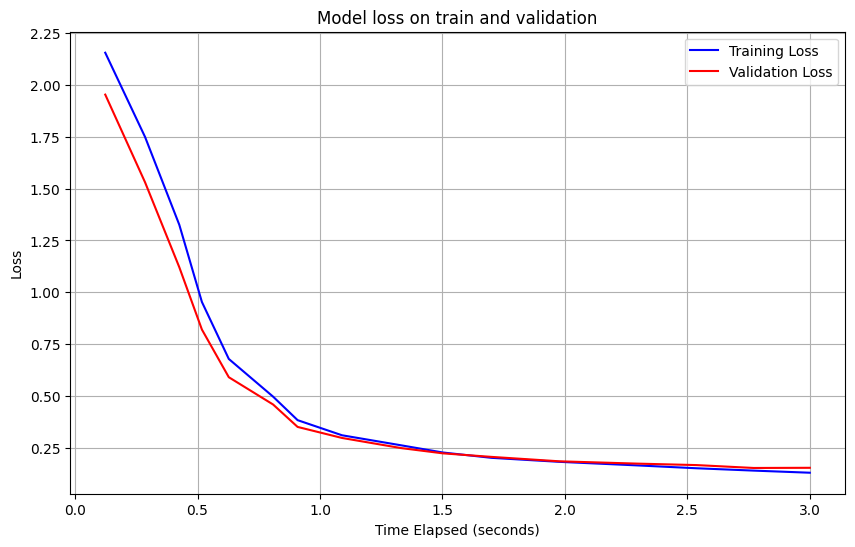

In [ ]:
device = torch.device('cuda')

model_b = model_b.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_b.parameters(), lr=1e-3)

train(model_b, dataloader_train, dataloader_val, labels_train, labels_val, device, criterion, optimizer)

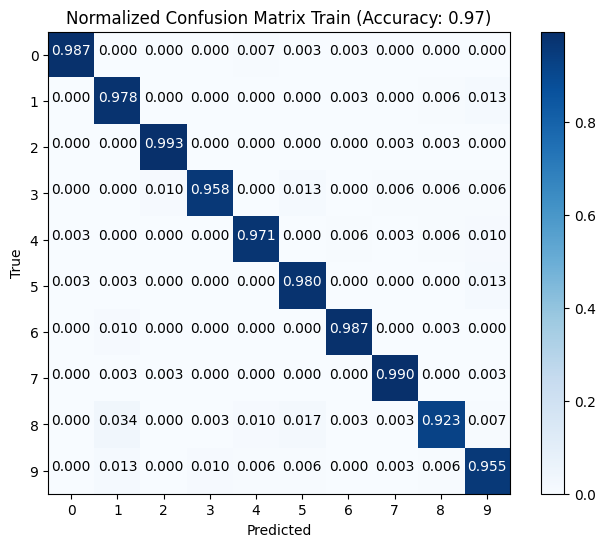

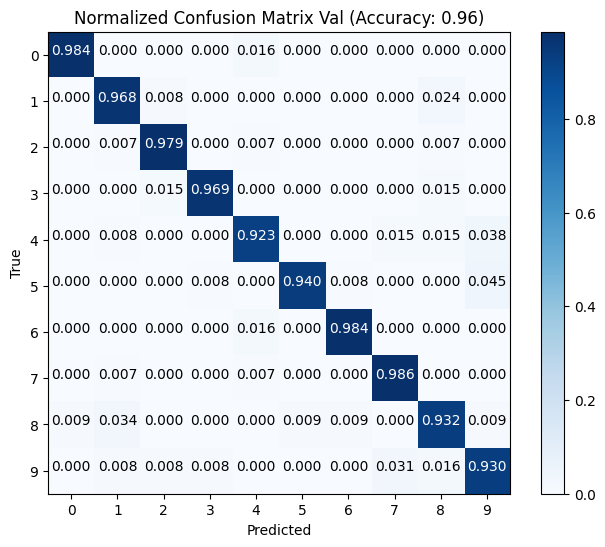

In [ ]:
# Conjunto de entrenamiento
train_accuracy, train_confusion_matrix = calculate_normalized_confusion_matrix_and_accuracy(model_b, dataloader_train, device)
plot_normalized_confusion_matrix(train_confusion_matrix, train_accuracy, "Train")

# Conjunto de validación
val_accuracy, val_confusion_matrix = calculate_normalized_confusion_matrix_and_accuracy(model_b, dataloader_val, device)
plot_normalized_confusion_matrix(val_confusion_matrix, val_accuracy, "Val")


### Caso (c)

Epoch 0: Train Loss: 2.2255 | Train Accuracy: 20.71% | Validation Loss: 2.0911 | Validation Accuracy: 38.16% | Time Elapsed: 0.16 seconds
Epoch 1: Train Loss: 1.9834 | Train Accuracy: 33.88% | Validation Loss: 1.8641 | Validation Accuracy: 47.62% | Time Elapsed: 0.09 seconds
Epoch 2: Train Loss: 1.7780 | Train Accuracy: 42.80% | Validation Loss: 1.6773 | Validation Accuracy: 54.18% | Time Elapsed: 0.19 seconds
Epoch 3: Train Loss: 1.6006 | Train Accuracy: 49.75% | Validation Loss: 1.5071 | Validation Accuracy: 59.31% | Time Elapsed: 0.09 seconds
Epoch 4: Train Loss: 1.4449 | Train Accuracy: 55.38% | Validation Loss: 1.3774 | Validation Accuracy: 63.51% | Time Elapsed: 0.10 seconds
Epoch 5: Train Loss: 1.3088 | Train Accuracy: 59.97% | Validation Loss: 1.2354 | Validation Accuracy: 66.93% | Time Elapsed: 0.20 seconds
Epoch 6: Train Loss: 1.1884 | Train Accuracy: 63.58% | Validation Loss: 1.1263 | Validation Accuracy: 69.66% | Time Elapsed: 0.10 seconds
Epoch 7: Train Loss: 1.0804 | Trai

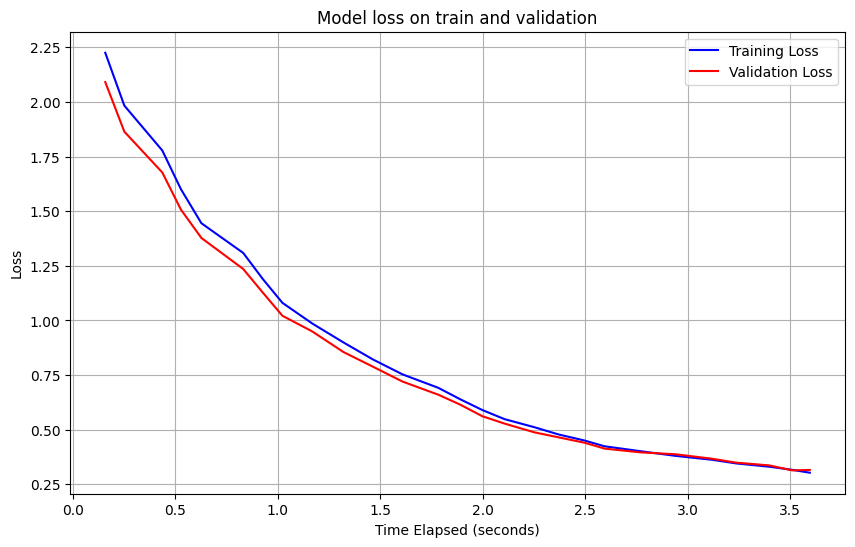

In [ ]:
device = torch.device('cuda')

model_c = model_c.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_c.parameters(), lr=1e-3)

train(model_c, dataloader_train, dataloader_val, labels_train, labels_val, device, criterion, optimizer)

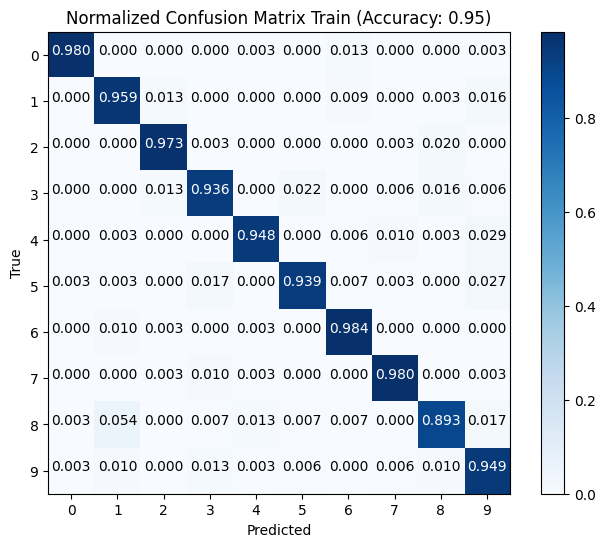

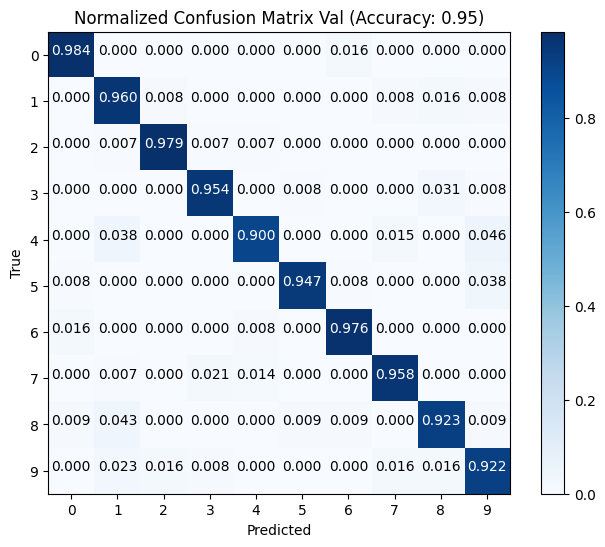

In [ ]:
# Conjunto de entrenamiento
train_accuracy, train_confusion_matrix = calculate_normalized_confusion_matrix_and_accuracy(model_c, dataloader_train, device)
plot_normalized_confusion_matrix(train_confusion_matrix, train_accuracy, "Train")

# Conjunto de validación
val_accuracy, val_confusion_matrix = calculate_normalized_confusion_matrix_and_accuracy(model_c, dataloader_val, device)
plot_normalized_confusion_matrix(val_confusion_matrix, val_accuracy, "Val")


### Caso (d)

Epoch 0: Train Loss: 2.0382 | Train Accuracy: 38.89% | Validation Loss: 1.7441 | Validation Accuracy: 65.06% | Time Elapsed: 0.07 seconds
Epoch 1: Train Loss: 1.5146 | Train Accuracy: 57.53% | Validation Loss: 1.2859 | Validation Accuracy: 73.75% | Time Elapsed: 0.08 seconds
Epoch 2: Train Loss: 1.1264 | Train Accuracy: 66.87% | Validation Loss: 0.9663 | Validation Accuracy: 78.03% | Time Elapsed: 0.09 seconds
Epoch 3: Train Loss: 0.8499 | Train Accuracy: 72.43% | Validation Loss: 0.7328 | Validation Accuracy: 80.96% | Time Elapsed: 0.09 seconds
Epoch 4: Train Loss: 0.6573 | Train Accuracy: 76.12% | Validation Loss: 0.5725 | Validation Accuracy: 83.10% | Time Elapsed: 0.08 seconds
Epoch 5: Train Loss: 0.5235 | Train Accuracy: 78.84% | Validation Loss: 0.4673 | Validation Accuracy: 84.66% | Time Elapsed: 0.08 seconds
Epoch 6: Train Loss: 0.4302 | Train Accuracy: 80.91% | Validation Loss: 0.3917 | Validation Accuracy: 85.91% | Time Elapsed: 0.09 seconds
Epoch 7: Train Loss: 0.3639 | Trai

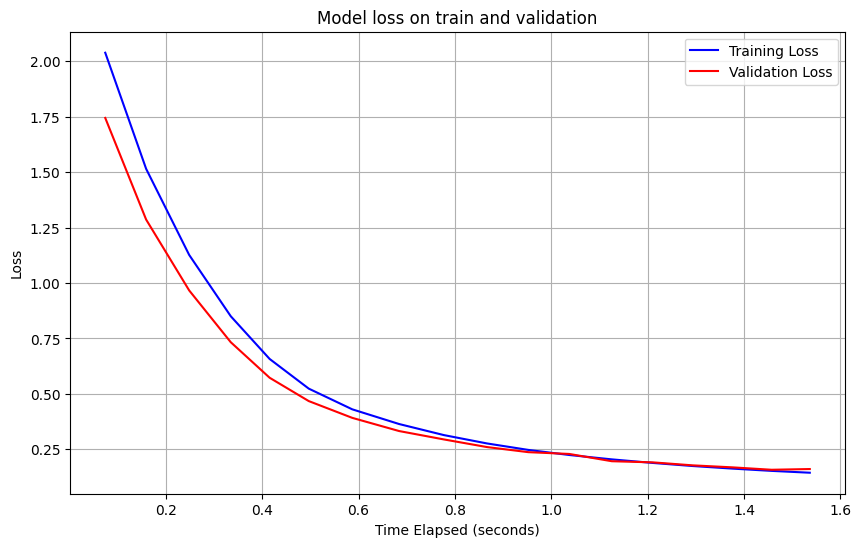

In [ ]:
device = torch.device('cuda')

model_d = model_d.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_d.parameters(), lr=1e-3)

train(model_d, dataloader_train, dataloader_val, labels_train, labels_val, device, criterion, optimizer)

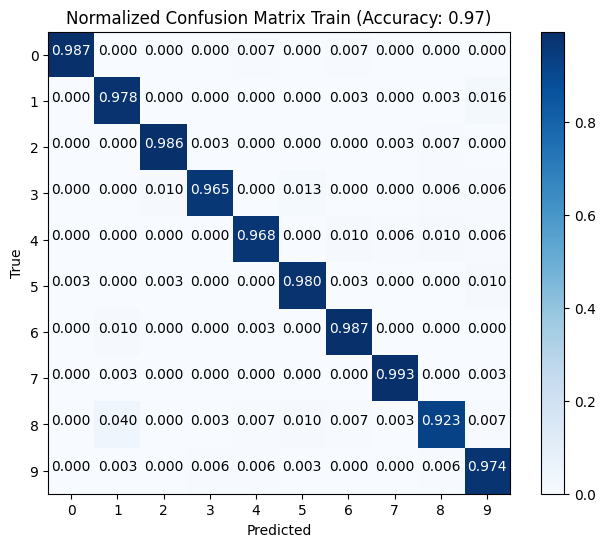

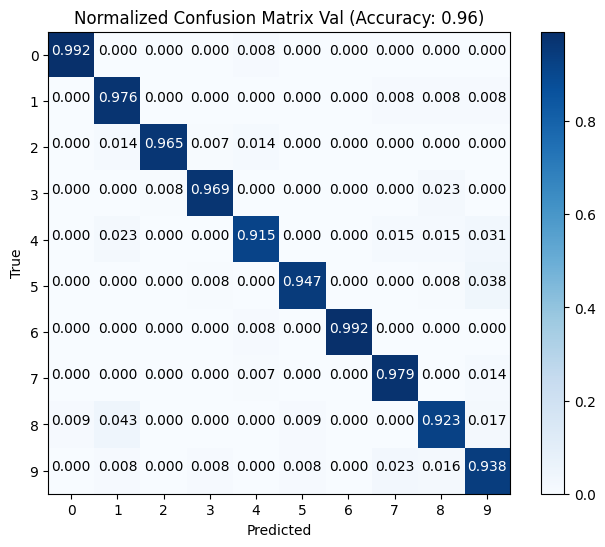

In [ ]:
# Conjunto de entrenamiento
train_accuracy, train_confusion_matrix = calculate_normalized_confusion_matrix_and_accuracy(model_d, dataloader_train, device)
plot_normalized_confusion_matrix(train_confusion_matrix, train_accuracy, "Train")

# Conjunto de validación
val_accuracy, val_confusion_matrix = calculate_normalized_confusion_matrix_and_accuracy(model_d, dataloader_val, device)
plot_normalized_confusion_matrix(val_confusion_matrix, val_accuracy, "Val")


### Caso (e)

Epoch 0: Train Loss: 2.2987 | Train Accuracy: 8.97% | Validation Loss: 2.2765 | Validation Accuracy: 10.27% | Time Elapsed: 0.08 seconds
Epoch 1: Train Loss: 2.2268 | Train Accuracy: 12.02% | Validation Loss: 2.1715 | Validation Accuracy: 16.05% | Time Elapsed: 0.07 seconds
Epoch 2: Train Loss: 2.1179 | Train Accuracy: 17.94% | Validation Loss: 2.0267 | Validation Accuracy: 22.94% | Time Elapsed: 0.07 seconds
Epoch 3: Train Loss: 1.9439 | Train Accuracy: 23.49% | Validation Loss: 1.8151 | Validation Accuracy: 28.39% | Time Elapsed: 0.06 seconds
Epoch 4: Train Loss: 1.6890 | Train Accuracy: 28.26% | Validation Loss: 1.5057 | Validation Accuracy: 34.50% | Time Elapsed: 0.07 seconds
Epoch 5: Train Loss: 1.3926 | Train Accuracy: 34.37% | Validation Loss: 1.2098 | Validation Accuracy: 40.50% | Time Elapsed: 0.06 seconds
Epoch 6: Train Loss: 1.1187 | Train Accuracy: 39.45% | Validation Loss: 0.9659 | Validation Accuracy: 45.06% | Time Elapsed: 0.07 seconds
Epoch 7: Train Loss: 0.9178 | Train

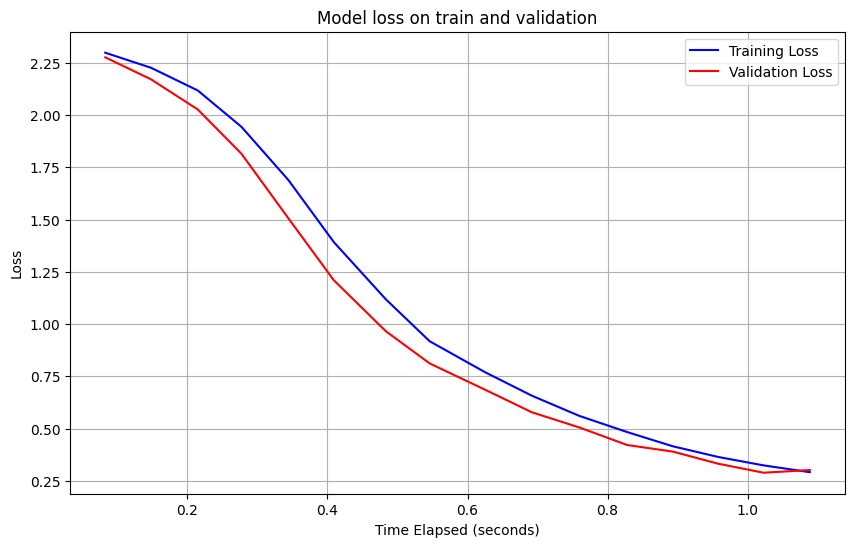

In [ ]:
device = torch.device('cuda')

model_e = model_e.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_e.parameters(), lr=1e-3)

train(model_e, dataloader_train, dataloader_val, labels_train, labels_val, device, criterion, optimizer)

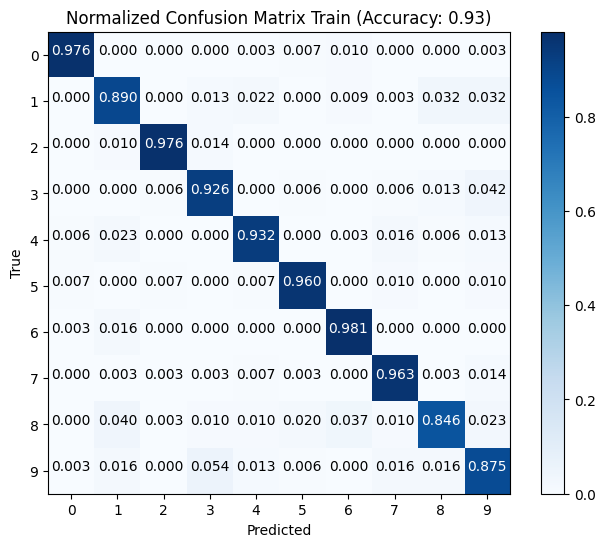

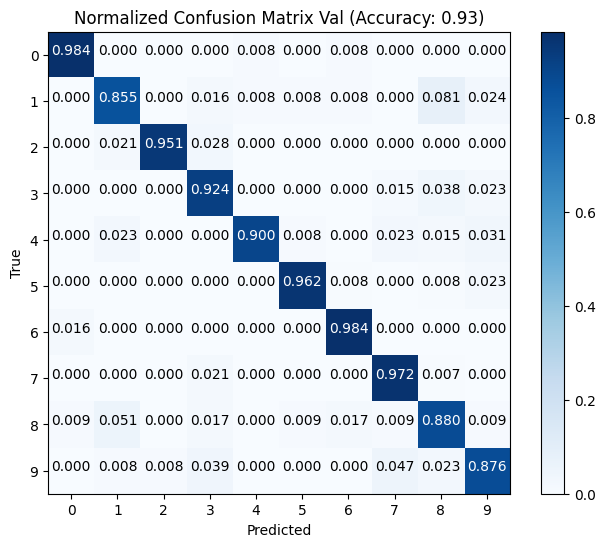

In [ ]:
# Conjunto de entrenamiento
train_accuracy, train_confusion_matrix = calculate_normalized_confusion_matrix_and_accuracy(model_e, dataloader_train, device)
plot_normalized_confusion_matrix(train_confusion_matrix, train_accuracy, "Train")

# Conjunto de validación
val_accuracy, val_confusion_matrix = calculate_normalized_confusion_matrix_and_accuracy(model_e, dataloader_val, device)
plot_normalized_confusion_matrix(val_confusion_matrix, val_accuracy, "Val")


### Caso (f)

Epoch 0: Train Loss: 2.1875 | Train Accuracy: 29.62% | Validation Loss: 2.0323 | Validation Accuracy: 54.71% | Time Elapsed: 0.07 seconds
Epoch 1: Train Loss: 1.8090 | Train Accuracy: 47.52% | Validation Loss: 1.5272 | Validation Accuracy: 64.79% | Time Elapsed: 0.07 seconds
Epoch 2: Train Loss: 1.2175 | Train Accuracy: 57.77% | Validation Loss: 0.9074 | Validation Accuracy: 71.37% | Time Elapsed: 0.06 seconds
Epoch 3: Train Loss: 0.6974 | Train Accuracy: 64.99% | Validation Loss: 0.5153 | Validation Accuracy: 75.88% | Time Elapsed: 0.07 seconds
Epoch 4: Train Loss: 0.4150 | Train Accuracy: 70.14% | Validation Loss: 0.3396 | Validation Accuracy: 78.97% | Time Elapsed: 0.07 seconds
Epoch 5: Train Loss: 0.2847 | Train Accuracy: 74.01% | Validation Loss: 0.2508 | Validation Accuracy: 81.46% | Time Elapsed: 0.06 seconds
Epoch 6: Train Loss: 0.2160 | Train Accuracy: 76.99% | Validation Loss: 0.1952 | Validation Accuracy: 83.32% | Time Elapsed: 0.07 seconds
Epoch 7: Train Loss: 0.1763 | Trai

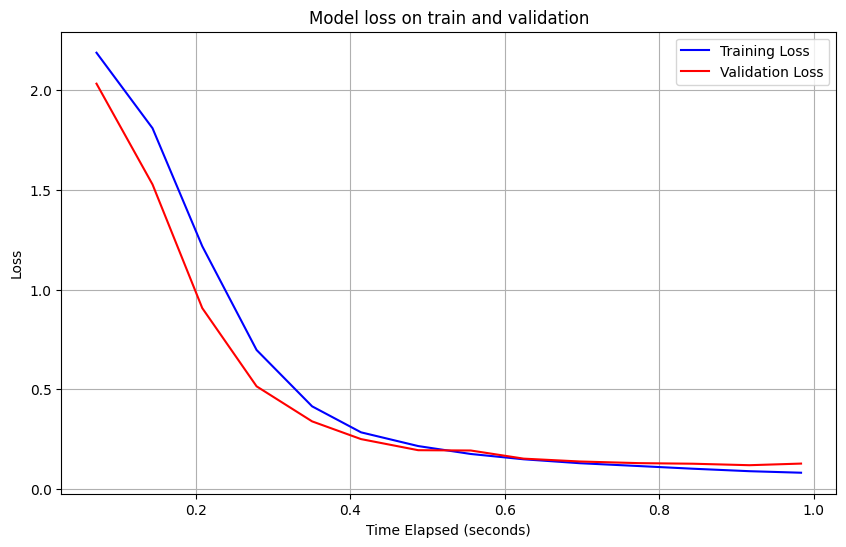

In [ ]:
device = torch.device('cuda')

model_f = model_f.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_f.parameters(), lr=1e-3)

train(model_f, dataloader_train, dataloader_val, labels_train, labels_val, device, criterion, optimizer)

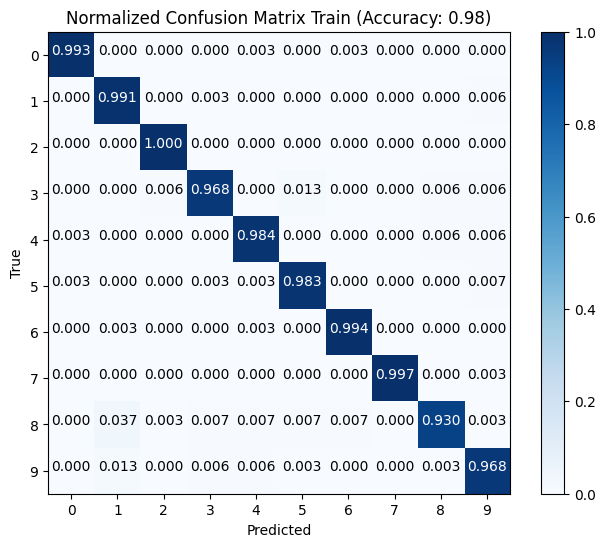

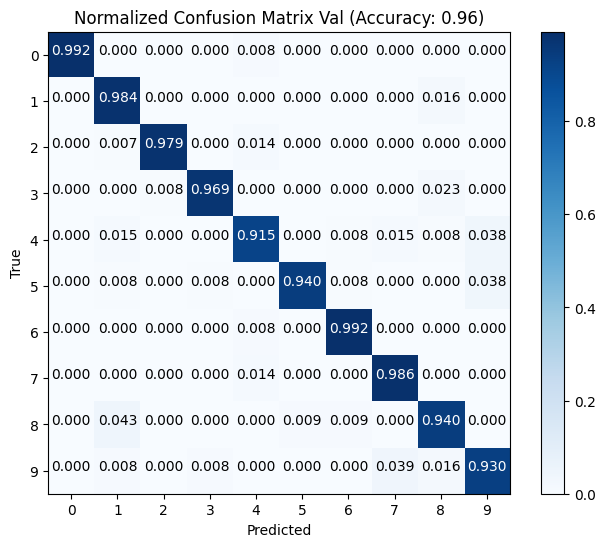

In [ ]:
# Conjunto de entrenamiento
train_accuracy, train_confusion_matrix = calculate_normalized_confusion_matrix_and_accuracy(model_f, dataloader_train, device)
plot_normalized_confusion_matrix(train_confusion_matrix, train_accuracy, "Train")

# Conjunto de validación
val_accuracy, val_confusion_matrix = calculate_normalized_confusion_matrix_and_accuracy(model_f, dataloader_val, device)
plot_normalized_confusion_matrix(val_confusion_matrix, val_accuracy, "Val")
